In [1]:
import numpy as np
import mkprop
from exlaser import doublewellproblem as prob
import matplotlib.pyplot as plt

n=1200
Hamiltonian = prob(n)

inr, nrm = Hamiltonian.getnrm()
nrm = lambda u : ((inr(u,u)).real)**0.5
#tend = 5.0
tnow=0
tend = 0.1
tol=1e-4
dtinit = 1e-3
u = Hamiltonian.getinitialstate()
y,info = mkprop.adaptivemidpoint(u,tnow,tend,dtinit,Hamiltonian,tol=tol)

In [2]:
np.set_printoptions(linewidth=180)
tol=1e-4
tnow = 0.822345
dts = np.geomspace(1e0,2e-3,20)
dts = np.geomspace(5e-1,2e-3,10)
nt = len(dts)

### compute reference solution

In [3]:

# define CFM routine to compute reference solution
c=15**0.5
cmat = [0.5-c/10, 0.5, 0.5+c/10]
a1 = [0.203952578716323,-0.059581898090478,0.015629319374155]
a2 = [0.133906069544898,0.314511533222506,-0.060893550742092]
a3 = [-0.014816639115506,-0.065414825819611,-0.014816639115506]
amat = [a1,a2,a3,a2[::-1],a1[::-1]]

jexps=len(amat)
print("use %d exponentials, requires a total time step t=%.2f"%(jexps,sum([abs(sum(a)) for a in amat])))


refsteps=2
tolkry=1e-14
Yref = mkprop.referenceCFM(u, tnow, dts, Hamiltonian, cmat, amat, refsteps, tolkry)

use 5 exponentials, requires a total time step t=1.19


### Midpoint scheme p=2, j=1, standard and symmetrized defect

In [4]:
tol=1e-13
tend=tnow+0.01
dtinit0 = (tend-tnow)/10
Yout1,info1 = mkprop.adaptivempnew(u,tnow,tend,dtinit0,Hamiltonian,tol=tol,testdt=dts)

In [5]:
Yout1sym,info1sym = mkprop.adaptivempsymnew(u,tnow,tend,dtinit0,Hamiltonian,tol=tol,testdt=dts)

In [6]:
errestlistp2j1 = info1[2]
errestlistp2j1sym = info1sym[2]
errlistp2j1 = np.zeros(dts.size)
errlistp2j1sym = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    testerr = nrm(Yref[:,ij]-Yout1[:,ij])
    errlistp2j1[ij]=testerr
    testerr = nrm(Yref[:,ij]-Yout1sym[:,ij])
    errlistp2j1sym[ij]=testerr
errdev1=abs(errestlistp2j1-errlistp2j1)
errdev2=abs(errestlistp2j1sym-errlistp2j1)

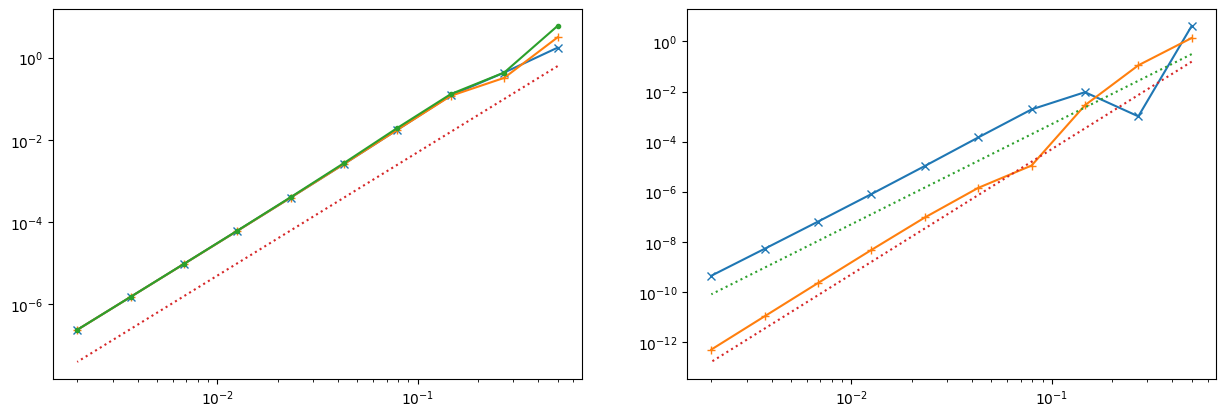

In [7]:
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.loglog(dts, errlistp2j1, 'x-',dts, errestlistp2j1sym,'+-',dts, errestlistp2j1,'.-',dts,5e0*dts**(3),':');
# deviation of error estimate from error, standard and symmetrized defect for midpoint scheme
ax2.loglog(dts, errdev1, 'x-',dts, errdev2,'+-',dts,5e0*dts**(4),':',dts,5e0*dts**(5),':');

### CFM p=4, j=2, standard defect

In [8]:
Yout1x,infox = mkprop.adaptiveCFMp4j2_stddef(u,tnow,tend,dtinit0,Hamiltonian,tol=tol,testdt=dts)

In [9]:
errestlistp4j2x = infox[2]
errlistp4j2x = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    testerr = nrm(Yref[:,ij]-Yout1x[:,ij])
    errlistp4j2x[ij]=testerr
devp4j2 = abs(errestlistp4j2x-errlistp4j2x)

### CFM p=4, j=2, symmetrized defect

In [10]:
Yout1,info = mkprop.adaptiveCFMp4j2(u,tnow,tend,dtinit0,Hamiltonian,tol=tol,testdt=dts)

In [11]:
errestlistp4j2 = info[2]
errlistp4j2 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    testerr = nrm(Yref[:,ij]-Yout1[:,ij])
    errlistp4j2[ij]=testerr
devp4j2sym = abs(errestlistp4j2-errlistp4j2)

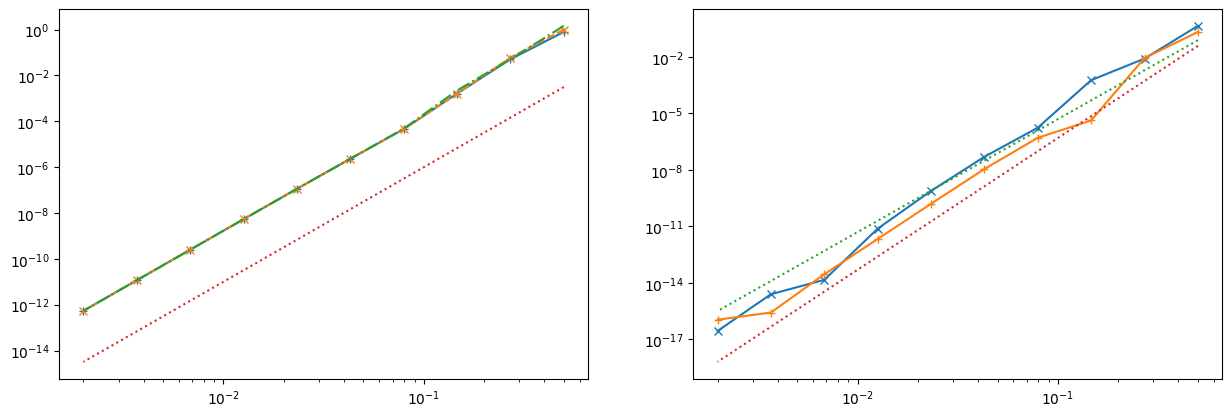

In [12]:
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.loglog(dts, errestlistp4j2,'+-',dts,errlistp4j2,'--x',dts,errestlistp4j2x,'-.',dts,1e-1*dts**(5),':');
# deviation of error estimate from error, standard and symmetrized defect for p=4 j=2
ax2.loglog(dts, devp4j2, 'x-',dts, devp4j2sym,'+-',dts,5e0*dts**(6),':',dts,5e0*dts**(7),':');

### CFM p=4, j=3, symmetrized defect

In [13]:
Yout1,info = mkprop.adaptiveCFMp4j3(u,tnow,tend,dtinit0,Hamiltonian,tol=1e-8,testdt=dts)
errestlistp4j3 = info[2]

errlistp4j3 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    testerr = nrm(Yref[:,ij]-Yout1[:,ij])
    errlistp4j3[ij]=testerr       
devp4j3sym = abs(errlistp4j3-errestlistp4j3)

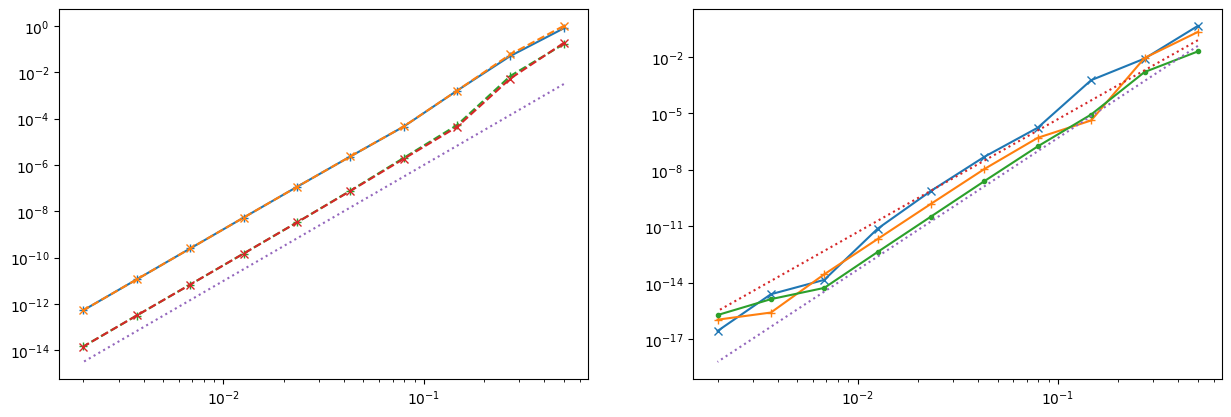

In [14]:
p = 4
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.loglog(dts, errestlistp4j2,'+-',dts,errlistp4j2,'--x',dts,errestlistp4j3,'--+',dts,errlistp4j3,'--x',dts,1e-1*dts**(5),':');
# deviation of error estimate from error, standard and symmetrized defect for p=4 j=2
ax2.loglog(dts, devp4j2, 'x-',dts, devp4j2sym,'+-',dts,devp4j3sym,'.-',dts,5e0*dts**(6),':',dts,5e0*dts**(7),':');

### CFM BKK4

In [15]:
Yout1,info = mkprop.adaptiveCFMBBK4(u,tnow,tend,dtinit0,Hamiltonian,tol=1e-8,testdt=dts)
errestlistBBK4 = info[2]

errlistBBK4 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    testerr = nrm(Yref[:,ij]-Yout1[:,ij])
    errlistBBK4[ij]=testerr


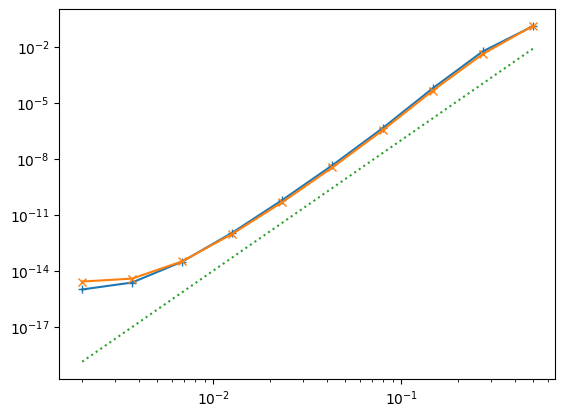

In [16]:
p=6
plt.loglog(dts, errestlistBBK4,'+-',dts,errlistBBK4,'-x',dts,1e0*dts**(p+1),':')

### full plot

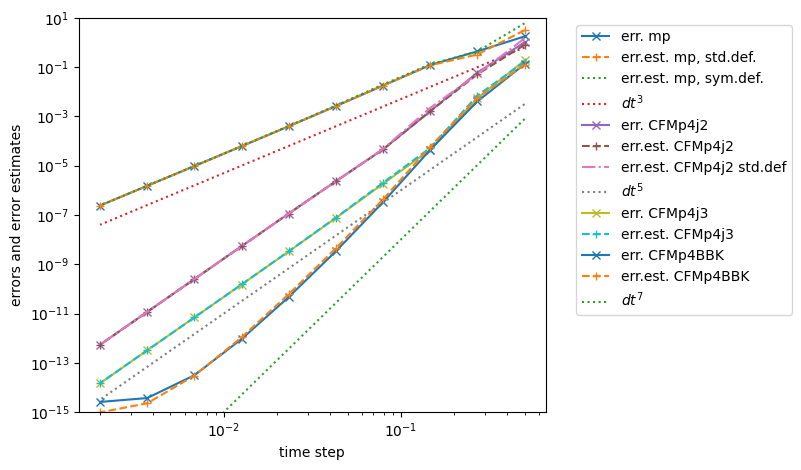

In [17]:
plt.figure(figsize=(8.2,4.8))
plt.loglog(dts, errlistp2j1, '-x',dts, errestlistp2j1sym,'+--',dts, errestlistp2j1,':',dts,5e0*dts**(3),':');
plt.loglog(dts,errlistp4j2,'-x',dts, errestlistp4j2,'+--',dts,errestlistp4j2x,'-.',dts,1e-1*dts**5,':')
plt.loglog(dts,errlistp4j3,'-x',dts, errestlistp4j3,'+--')
plt.loglog(dts,errlistBBK4,'-x',dts, errestlistBBK4,'+--',dts,1e-1*dts**7,':');
plt.xlabel('time step')
plt.ylabel('errors and error estimates')
plt.gca().legend(('err. mp','err.est. mp, std.def.','err.est. mp, sym.def.','$dt^3$',
                  'err. CFMp4j2','err.est. CFMp4j2','err.est. CFMp4j2 std.def','$dt^5$',
                  'err. CFMp4j3','err.est. CFMp4j3',
                  'err. CFMp4BBK','err.est. CFMp4BBK','$dt^7$'),
                  bbox_to_anchor=(1.05, 1.0)) # loc='upper left'
#plt.xlim(2e-3,1e0)
plt.ylim(1e-15,1e1)
plt.tight_layout()
plt.savefig("asymptoticerror.pdf", format="pdf", bbox_inches="tight")
plt.savefig("asymptoticerror.png")